# Minicurso Ciência de Dados na Prática usando Python
## Parte 4 - Análise de Dados e Aprendizado de Máquina

## Avaliação de Carros

Neste notebook apresentamos um problema de classificação de carros. Usaremos algumas técnicas de machine learning e compararemos os resultados obtidos.

In [49]:
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import math
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


## Carregamento dos dados

In [73]:
newdata = pd.read_csv('carros.csv')

### Tratamento dos dados

Os atributos da base de dados são os descritos na lista abaixo chamada colunas. Nomearemos cada coluna do dataset de acordo com o nome de sua respectiva característica.

In [74]:
colunas = ['buying','maint','doors','persons','lug_boot','safety','class']
newdata.columns = colunas

Abaixo é apresentado algumas linhas do conjunto de dados.

In [75]:
newdata.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


A função info() nos mostra que o conjunto de dados possui 1727 instância onde cada atributo não possui valores nulos. Dessa maneira, não nos preocuparemos em tratar valores nulos neste conjunto.

In [76]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
buying      1727 non-null object
maint       1727 non-null object
doors       1727 non-null object
persons     1727 non-null object
lug_boot    1727 non-null object
safety      1727 non-null object
class       1727 non-null object
dtypes: object(7)
memory usage: 94.5+ KB


A função describe nos mostra quantas instância cada atributo possui, além de quantos valores únicos, o valor de atributo mais frequente e a quantidade que o atributo mais frequente aparece.

In [77]:
newdata.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1727,1727,1727,1727,1727,1727,1727
unique,4,4,4,3,3,3,4
top,high,high,3,4,med,high,unacc
freq,432,432,432,576,576,576,1209


Nossa base de dados não possui dados inconsistentes tampouco faltantes porém, possui muitos dados categóricos. Dessa maneira, temos que tornar esse dados categóricos em dados numéricos. A seguir mapeamos cada valor de atributo para um valor inteiro e substituimos no dataset.

In [78]:
mapa = {'low':1,'med':2,'high':3,'vhigh':4}
mapaClasses = {'unacc':0,'acc':1,'good':2,'vgood':3}
doors = {'2':2, '3':3, '4':4, '5more':5}
persons ={'2':2,'4':4,'more':5}
lug_boot = {'small':2,'med':3,'big':4}
safety = {'low':4, 'med':3, 'high':2}

In [79]:
newdata.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [80]:
newdata['buying'] =  newdata['buying'].map(mapa)
newdata['maint'] = newdata['maint'].map(mapa)
newdata['doors'] = newdata['doors'].map(doors)
newdata['persons'] = newdata['persons'].map(persons)
newdata['lug_boot'] = newdata['lug_boot'].map(lug_boot)
newdata['safety'] = newdata['safety'].map(safety)
newdata['class'] = newdata['class'].map(mapaClasses)

O resultado da transformação está mostrado abaixo.

In [81]:
newdata.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,4,4,2,2,2,3,0
1,4,4,2,2,2,2,0
2,4,4,2,2,3,4,0
3,4,4,2,2,3,3,0
4,4,4,2,2,3,2,0


#### Separamos 70% dos dados para treino e 30% para teste

In [58]:
indice = math.ceil(len(newdata)*0.7)
treino = newdata[:indice]
teste = newdata[indice:]
X = treino[colunas[:-1]]
Y = treino[colunas[-1]]
X_teste = teste[colunas[:-1]]
Y_teste = teste[colunas[-1]]

In [59]:
corr = newdata.corr()
corr

,buying,maint,doors,persons,lug_boot,safety,class
buying,1.000000,-0.001043,0.001043,0.001039,0.000952,-0.000952,-0.282488
maint,-0.001043,1.000000,0.001043,0.001039,0.000952,-0.000952,-0.232128
doors,0.001043,0.001043,1.000000,-0.001039,-0.000952,0.000952,0.065662
persons,0.001039,0.001039,-0.001039,1.000000,-0.000949,0.000949,0.373253
lug_boot,0.000952,0.000952,-0.000952,-0.000949,1.000000,0.000869,0.157617
safety,-0.000952,-0.000952,0.000952,0.000949,0.000869,1.000000,-0.439171
class,-0.282488,-0.232128,0.065662,0.373253,0.157617,-0.439171,1.000000


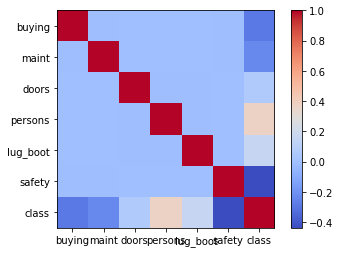

In [60]:
# https://matplotlib.org/users/colormaps.html
plt.imshow(corr, cmap='coolwarm', interpolation=None)  
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)  
plt.yticks(range(len(corr)), corr.columns);

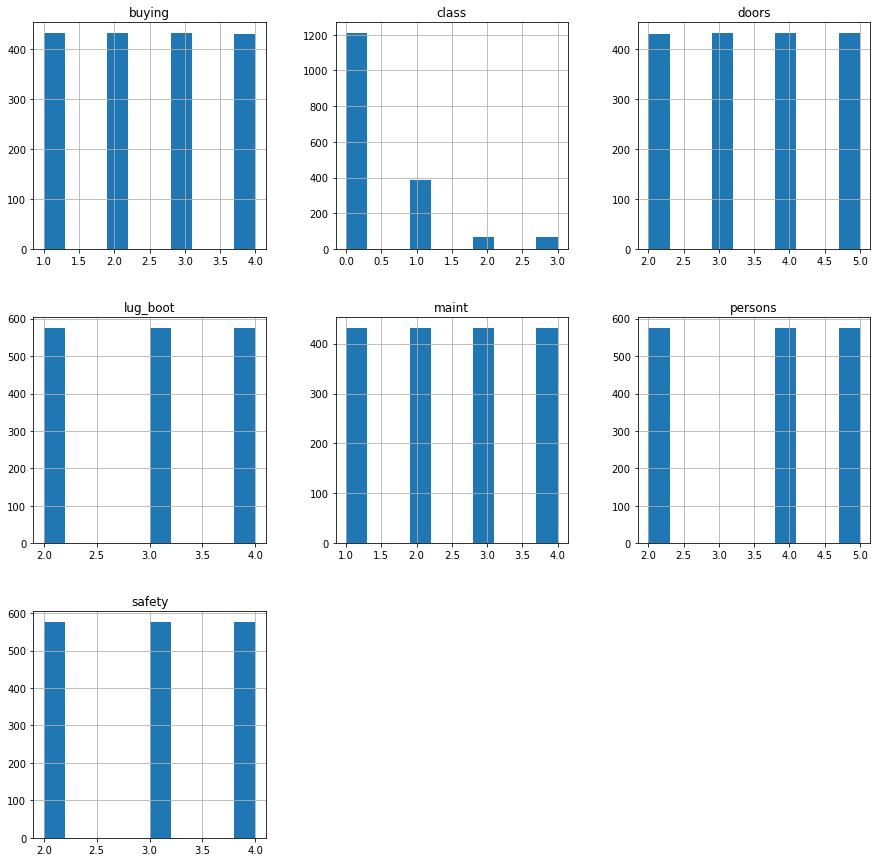

In [61]:
newdata.hist(figsize=(15,15));

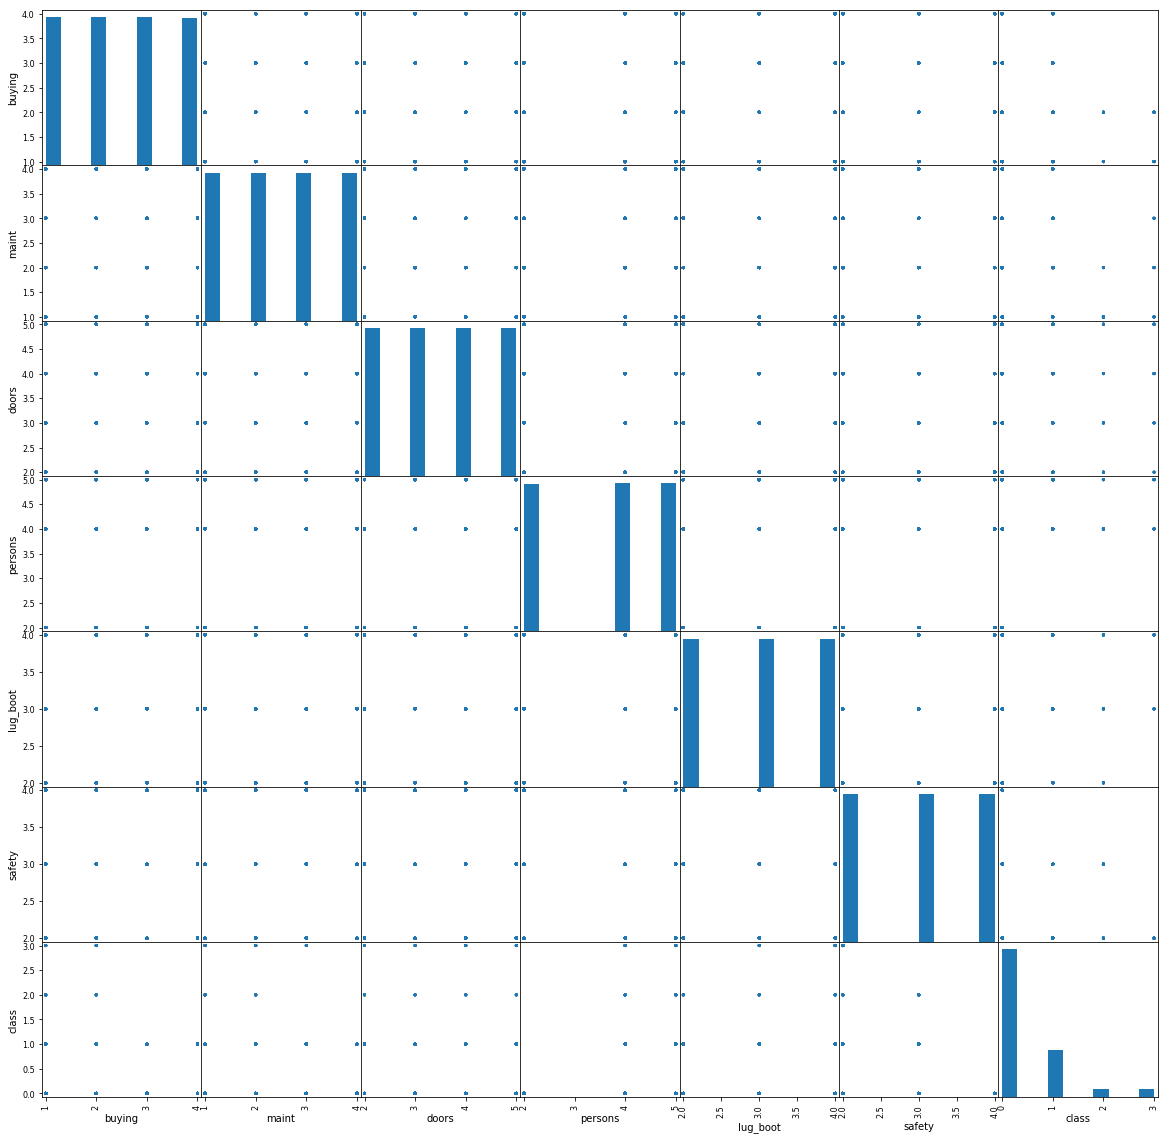

In [62]:
pd.plotting.scatter_matrix(newdata, figsize=(20,20));

## Criação dos modelos 

### Árvore de Decisão

É um método de aprendizagem supervisionada não-paramétrica usado para classificação e regressão. O objetivo é criar um modelo que preveja o valor de uma variável de destino aprendendo regras de decisão simples inferidas dos recursos de dados. A seguir, usaremos esta técnica para classificar os carros.

In [63]:
classificador = tree.DecisionTreeClassifier()
classificador = classificador.fit(X,Y)

In [64]:
resultDecisionTree = model_selection.cross_val_score(classificador,X,Y,cv=3)
mediaDT = np.average(resultDecisionTree)
predicoes = classificador.predict(X_teste.values)
print("Acurácia: ",accuracy_score(Y_teste.values,predicoes))
print("Recall: ",recall_score(Y_teste.values,predicoes,average='macro'))
print("Precisão: ", precision_score(Y_teste.values,predicoes,average='macro'))
print("F1: ", f1_score(Y_teste.values,predicoes,average='macro'))
print("Media cross validation:",mediaDT)

Acurácia:  0.864864864865
Recall:  0.730242846904
Precisão:  0.870299086126
F1:  0.750580838486
Media cross validation: 0.819811033472


### Knn

KNN é um classificador onde o aprendizado é baseado na analogia. O conjunto de treinamento é formado por vetores n-dimensionais e cada elemento deste conjunto representa um ponto no espaço n-dimensional. Para  determinar  a  classe   de um elemento que não pertença ao conjunto de treinamento, o classificador KNN procura K elementos do conjunto de treinamento que estejam mais próximos deste elemento desconhecido, ou seja, que tenham a menor distância. Estes K elementos são chamados de K-vizinhos mais próximos. Verifica-se quais são as classes desses K vizinhos e a classe mais frequente será atribuída à classe do elemento desconhecido. 

In [65]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X,Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [66]:
resultKnn = model_selection.cross_val_score(neigh,X,Y,cv=3)
mediaKnn = np.average(resultKnn)
predicoesKnn = neigh.predict(X_teste.values)
#print(mediaKnn)
#print(confusion_matrix(Y_teste.values,predicoesKnn))
print("Acurácia: ",accuracy_score(Y_teste.values,predicoesKnn))
print("Recall: ",recall_score(Y_teste.values,predicoesKnn,average='macro'))
print("Precisão: ", precision_score(Y_teste.values,predicoesKnn,average='macro'))
print("F1: ", f1_score(Y_teste.values,predicoesKnn,average='macro'))
print("Media cross validation:",mediaKnn)

Acurácia:  0.781853281853
Recall:  0.563776025874
Precisão:  0.599934932144
F1:  0.545153039475
Media cross validation: 0.840351678559


### SVM

In [67]:
clf = svm.SVC()
clf.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [68]:
resultSVM = model_selection.cross_val_score(clf,X,Y)
predicoesSVM = clf.predict(X_teste.values)

mediaSVM = np.average(resultSVM)
#print(mediaSVM)
#print(confusion_matrix(Y_teste.values,predicoesKnn))

print("Acurácia: ",accuracy_score(Y_teste.values,predicoesSVM))
print("Recall: ",recall_score(Y_teste.values,predicoesSVM,average='micro'))
print("Precisão: ", precision_score(Y_teste.values,predicoesSVM,average='micro'))
print("F1: ", f1_score(Y_teste.values,predicoesSVM,average='micro'))
print("Media cross validation:",mediaSVM)

Acurácia:  0.718146718147
Recall:  0.718146718147
Precisão:  0.718146718147
F1:  0.718146718147
Media cross validation: 0.88984428368


### Naive Bayes

O Classificador Naive Bayes é provavelmente o classificador mais utilizado em Machine Learning. O classificador é denominado ingênuo (“naive”) por assumir que os atributos sao condicionalmente independentes, ou seja, a informacao de um evento não é informativa sobre nenhum outro. Apesar desta premissa “ingênua” e simplista, o classificador reporta o melhor desempenho em varias tarefas de classificacão. 

In [69]:
gnb = GaussianNB()
y_pred = gnb.fit(X,Y)

In [70]:
resultNB = model_selection.cross_val_score(gnb,X,Y,cv=3)
predicoesNB = gnb.predict(X_teste.values)
mediaNB = np.average(resultNB)
print("Acurácia: ",accuracy_score(predicoesNB,Y_teste.values))
print("Recall: ",recall_score(Y_teste.values,predicoesSVM,average='micro'))
print("Precisão: ", precision_score(Y_teste.values,predicoesSVM,average='micro'))
print("F1: ", f1_score(Y_teste.values,predicoesSVM,average='micro'))
print("Media cross validation:",mediaNB)

Acurácia:  0.727799227799
Recall:  0.718146718147
Precisão:  0.718146718147
F1:  0.718146718147
Media cross validation: 0.856915055595


O gráfico abaixo, mostra o desempenho de cada técnica através da validação cruzada - <i>cross validation</i>.

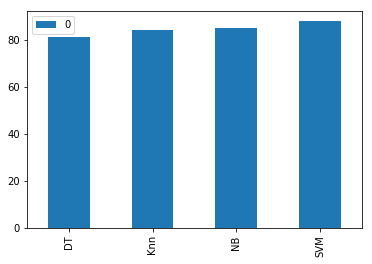

In [71]:
pd.DataFrame([int(mediaDT*100),int(mediaKnn*100),int(mediaNB*100), int(mediaSVM*100)], 
             index=['DT', 'Knn', 'NB', 'SVM']).plot(kind='bar')

### Referências

https://www.maxwell.vrac.puc-rio.br/7587/7587_6.PDF <br>
https://www.maxwell.vrac.puc-rio.br/9947/9947_5.PDF <br>
http://scikit-learn.org/stable/